## Packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from warnings import filterwarnings
from pprint import pprint
import pickle
filterwarnings("ignore")
%matplotlib inline

## Global Parameters

In [2]:
ROOT_DIRECTORY = "/home/kaan.aytekin/Thesis"
#ROOT_DIRECTORY = "/Users/kaan.aytekin/Desktop/Kaan/Thesis"
SIMULATION_DURATION = 90 * 60 #Seconds
WARM_UP_PERIOD_DURATION = 15 * 60 #Seconds
COOL_DOWN_PERIOD_DURATION = 15 * 60 #Seconds
DETECTOR_SEPARATION_DISTANCE = 500 #Meter
DETECTOR_COUNT = 21
TOTAL_ROAD_LENGTH = DETECTOR_COUNT * DETECTOR_SEPARATION_DISTANCE

### UDFs

In [3]:
def timeit(func):
    """Wrapper function for logging the function duration

    Args:
        func (function): Function to measure performance

    Returns:
        function: Function with performance measurement capabilities
    """
    from functools import wraps
    import datetime as dt
    @wraps(func)
    def timed(*args, **kwargs):
        function_name = func.__name__
        start_time = dt.datetime.now()
        result = func(*args, **kwargs)
        end_time = dt.datetime.now()
        execution_duration = (end_time - start_time).total_seconds()
        print(
            f"Function {function_name!r} executed in {execution_duration:.4f} seconds ({execution_duration/60:.2f} minutes)")
        return result
    return timed
@timeit
def plot_detector_timelines(df, detector_metric, detector_numbers, simulation_configs):
    detector_metric_name_map = {
        "flow_vehph": "Flow(Veh/Hr)",
        "density_vehpkm": "Density(Veh/Km)",
        "avg_speed_kmph": "Speed(Km/Hr)",
        "section_travel_time_sec": "Travel Time(Sec)",
        "delay_time_sec": "Delay Time(Sec)",
    }
    detector_metric_name = detector_metric_name_map[detector_metric]
    # Data Filtering
    simulation_selector = None
    for key, value in simulation_configs.items():
        if simulation_selector is not None:
            simulation_selector = (simulation_selector) & (df[key] == value)
        else:
            simulation_selector = df[key] == value
    detector_selector = None
    for detector in detector_numbers:
        if detector_selector is not None:
            detector_selector = (detector_selector) | (
                df["detector_number"] == detector
            )
        else:
            detector_selector = df["detector_number"] == detector
    plotting_columns = {
        "x": "timestamp",
        "y": detector_metric,
        "hue": "detector_number",
        # "style":"detector_number"
    }
    plotting_df = df[simulation_selector & detector_selector][
        list(set(plotting_columns.values()))
    ]
    # Plotting helpers
    max_metric_point = plotting_df[detector_metric].max()
    detector_numbers_str = f"{detector_numbers}".strip("[]")
    accident_start_time = simulation_configs["accident_start_time"]
    accident_duration = simulation_configs["accident_duration"]
    accident_detector = int(
        np.ceil(simulation_configs["accident_location"] / DETECTOR_SEPARATION_DISTANCE)
    )
    title = f"{detector_metric_name.split('(')[0]} distribution for Detector(s) {detector_numbers_str}\n Accident Configs: {simulation_configs}\nAccident in detector {accident_detector}"
    # Plotting
    figure(num=None, figsize=(20, 12), dpi=80, facecolor="w", edgecolor="k")
    # ax = sns.lineplot(data=plotting_df,palette=sns.color_palette("Spectral",len(detector_numbers)),**plotting_columns)
    ax = sns.lineplot(
        data=plotting_df,
        palette=sns.color_palette("husl", len(detector_numbers)),
        **plotting_columns,
    )
    ax.set(title=title, xlabel="Timestamp(sec)", ylabel=detector_metric_name)
    plt.vlines(
        x=accident_start_time,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.vlines(
        x=accident_start_time + accident_duration,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.show()

def prepare_data_for_prediction(df,simulation_configs,scaler,encoder):
    df_copy = df.copy()
    accident_lane_df = pd.DataFrame(encoder.transform(df_copy[["accident_lane"]]).toarray())
    df_copy = df_copy.reset_index(drop=True)
    accident_lane_df = accident_lane_df.reset_index(drop=True)
    accident_lane_df.columns = encoder.get_feature_names(["accident_lane"])
    df_concat = pd.concat([accident_lane_df,df_copy],axis = 1)
    simulation_selector = None
    for key, value in simulation_configs.items():
        if simulation_selector is not None:
            simulation_selector = (simulation_selector) & (df_concat[key] == value)
        else:
            simulation_selector = df_concat[key] == value
    
    df_reduced = df_concat[simulation_selector]
    df_model = df_reduced[FEATURE_COLUMNS]
    df_model_scaled = scaler.transform(df_model)    
    return df_model_scaled, df_reduced.target.values

def get_delay_predictions(df,simulation_configs):
    df_model, y_real = prepare_data_for_prediction(
        df=df,
        simulation_configs=simulation_configs,
        scaler=min_max_scaler,
        encoder=one_hot_encoder
    )
    y_pred = rf_regressor.predict(df_model)
    prediction_error = y_real - y_pred
    cumulative_error = np.cumsum(prediction_error)
    result_df = pd.DataFrame(
        {
            "actual_delay": y_real,
            "predicted_delay": y_pred,
            "prediction_error": prediction_error,
            #"cumulative_error": cumulative_error
        }
    )
    return result_df

def plot_delay_predictions(df,simulation_configs):
    result_df = get_delay_predictions(df,simulation_configs)
    accident_detector = int(
        np.ceil(simulation_configs["accident_location"] / DETECTOR_SEPARATION_DISTANCE)
    )
    detector_number = simulation_configs.get("detector_number")
    title = f"Delay prediction for Detector {detector_number}\n Accident Configs: {simulation_configs}\nAccident in detector {accident_detector}"
    figure(num=None, figsize=(20, 12), dpi=80, facecolor="w", edgecolor="k")
    # ax = sns.lineplot(data=plotting_df,palette=sns.color_palette("Spectral",len(detector_numbers)),**plotting_columns)
    ax = sns.lineplot(
        data=result_df,
        #palette=sns.color_palette("husl", 4),
        palette=sns.color_palette("husl", 3),
    )
    ax.set(title=title, xlabel="Timestamp(sec)", ylabel="Delay Time(sec)")

### Load Data

In [4]:
processed_feature_columns_path = os.path.join(
    ROOT_DIRECTORY, "data/thesis_data/processed_feature_columns.txt"
)
with open(processed_feature_columns_path, "r") as reader:
    FEATURE_COLUMNS = reader.read().split("\n")

top_features_df = pd.read_csv(os.path.join(ROOT_DIRECTORY,"data/thesis_data/top_features.txt"))
selected_features = top_features_df.feature.to_list()
non_feature_columns = [
    "simulation_run",
    "connected_vehicle_ratio",
    "is_accident_simulation", 
    "accident_lane", 
]

df_train = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/x_train.csv")
)
y_train = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/y_train.csv")
)
df_train["target"] = y_train
df_test = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/x_test.csv")
)
y_test = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/y_test.csv")
)
df_test["target"] = y_test

df = df_train.append(df_test)

In [5]:
df.head()

,simulation_run,connected_vehicle_ratio,is_accident_simulation,accident_location,accident_start_time,accident_duration,accident_lane,prev_detector_detector_number,next_detector_detector_number,detector_number,...,prev_detector_density_vehpkm_lag9,prev_detector_avg_speed_kmph_lag9,prev_detector_section_travel_time_sec_lag9,prev_detector_delay_time_sec_lag9,prev_detector_flow_vehph_lag10,prev_detector_density_vehpkm_lag10,prev_detector_avg_speed_kmph_lag10,prev_detector_section_travel_time_sec_lag10,prev_detector_delay_time_sec_lag10,target
0,0,0.0,0,0,0,0,0,1.0,2.0,1,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,11.776478
1,0,0.0,0,0,0,0,0,1.0,2.0,1,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,18.261579
2,0,0.0,0,0,0,0,0,1.0,2.0,1,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,25.441548
3,0,0.0,0,0,0,0,0,1.0,2.0,1,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,15.226153
4,0,0.0,0,0,0,0,0,1.0,2.0,1,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,20.770317


### Load Model & Scalers

In [6]:
with open(os.path.join(ROOT_DIRECTORY,"model/random_forest_regressor.pkl"),"rb") as file:
    rf_regressor = pickle.load(file)

with open(os.path.join(ROOT_DIRECTORY,"model/min_max_scaler.pkl"),"rb") as file:
    min_max_scaler = pickle.load(file)

with open(os.path.join(ROOT_DIRECTORY,"model/one_hot_encoder.pkl"),"rb") as file:
    one_hot_encoder = pickle.load(file)
    

### Data Exploration (Temp)

In [7]:
def data_slicer(df, simulation_configs):
    # Data Filtering
    simulation_selector = None
    for key, value in simulation_configs.items():
        if simulation_selector is not None:
            simulation_selector = (simulation_selector) & (df[key] == value)
        else:
            simulation_selector = df[key] == value
    sliced_df = df[simulation_selector]
    return sliced_df

In [95]:
simulation_configs = {
    "is_accident_simulation" : 1,
    #"connected_vehicle_ratio" : 0.6,
    "accident_location" : 6636,
    "accident_start_time" : 2234,
    "accident_duration" : 1492,
    "accident_lane" : 1,
    "detector_number" : 14
}
data_slicer(df,simulation_configs).head(50)

,simulation_run,connected_vehicle_ratio,is_accident_simulation,accident_location,accident_start_time,accident_duration,accident_lane,prev_detector_detector_number,next_detector_detector_number,detector_number,...,prev_detector_density_vehpkm_lag9,prev_detector_avg_speed_kmph_lag9,prev_detector_section_travel_time_sec_lag9,prev_detector_delay_time_sec_lag9,prev_detector_flow_vehph_lag10,prev_detector_density_vehpkm_lag10,prev_detector_avg_speed_kmph_lag10,prev_detector_section_travel_time_sec_lag10,prev_detector_delay_time_sec_lag10,target
1202611,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,12.170385
1202612,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,10.408390
1202613,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,8.863038
1202614,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,8.182350
1202615,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,18.686764
1202616,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,11.447145
1202617,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,9.496589
1202618,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,7.268425
1202619,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,8.182350
1202620,32,0.0,1,6636,2234,1492,1,13.0,15.0,14,...,14.260870,64.028571,28.112450,10.871070,2000.0,14.260870,64.028571,28.112450,10.871070,6.487434


### Plot Prediction Results

### Accident vs No Accident

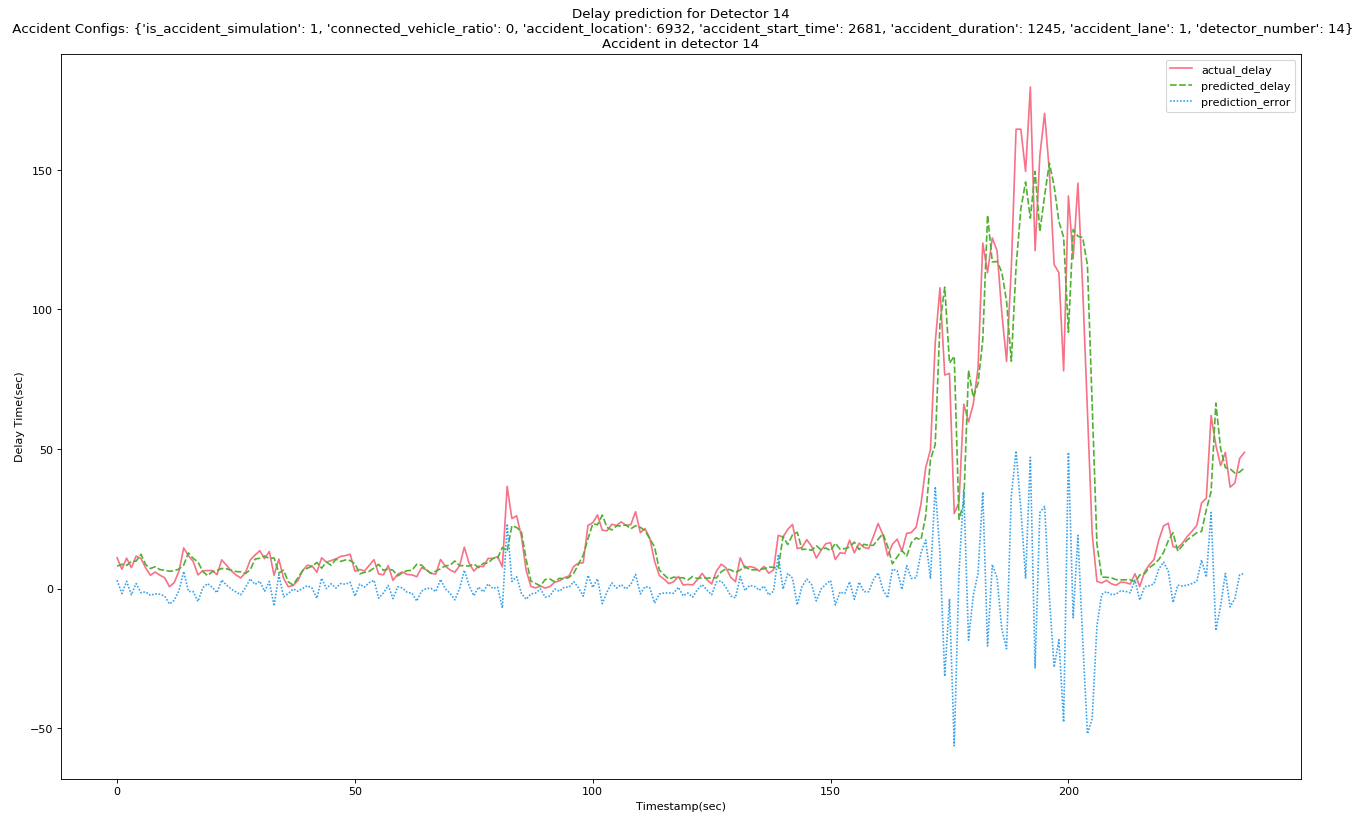

In [17]:
# Accident
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0,
    "accident_location" : 6932,
    "accident_start_time" : 2681,
    "accident_duration" : 1245,
    "accident_lane" : 1,
    "detector_number" : 14
}

plot_delay_predictions(df,simulation_configs)

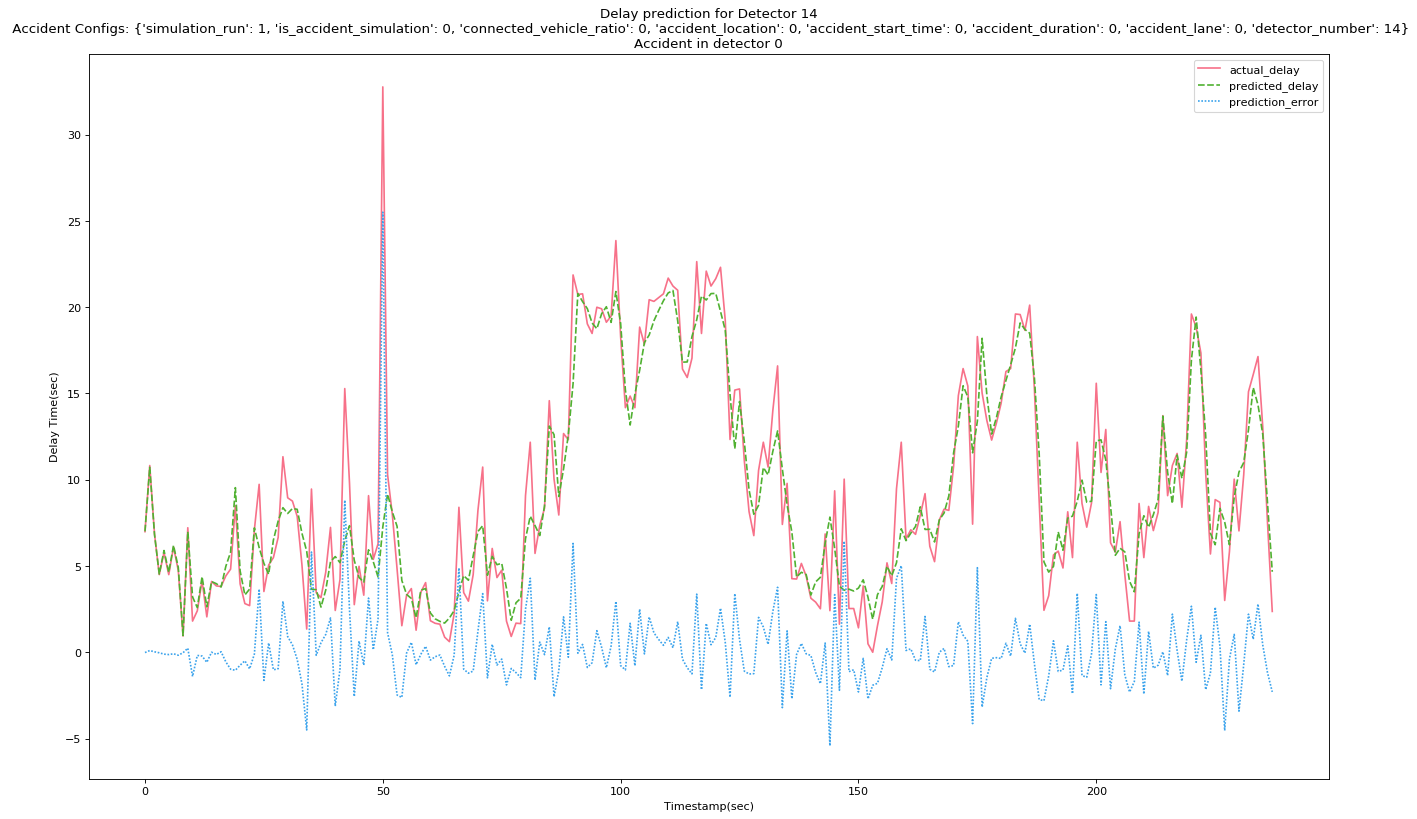

In [20]:
# No Accident
simulation_configs = {
    "simulation_run" : 1,
    "is_accident_simulation" : 0,
    "connected_vehicle_ratio" : 0,
    "accident_location" : 0,
    "accident_start_time" : 0,
    "accident_duration" : 0,
    "accident_lane" : 0,
    "detector_number" : 14
}
plot_delay_predictions(df,simulation_configs)

### Autonomous Percentage Change

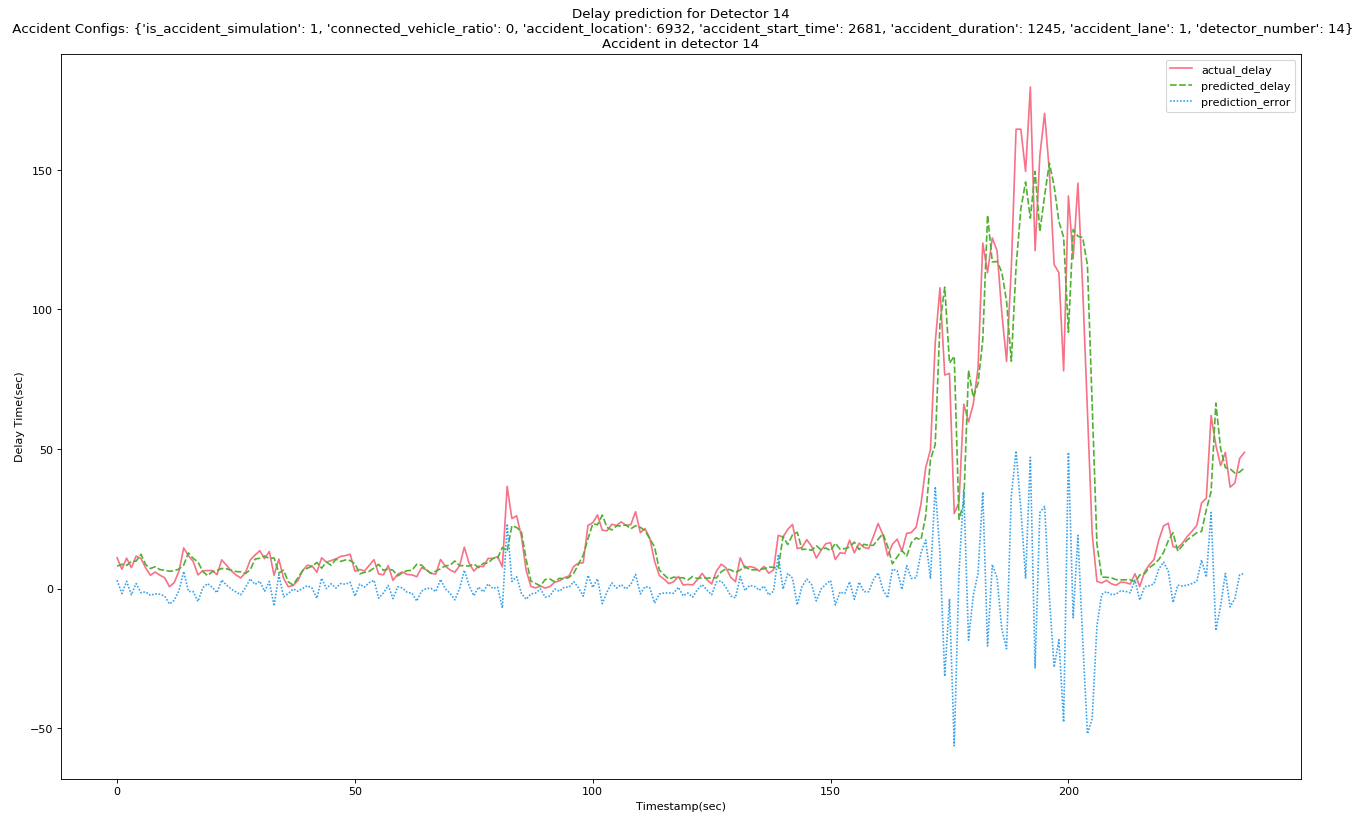

In [8]:
# CV 0%
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0,
    "accident_location" : 6932,
    "accident_start_time" : 2681,
    "accident_duration" : 1245,
    "accident_lane" : 1,
    "detector_number" : 14
}
plot_delay_predictions(df,simulation_configs)

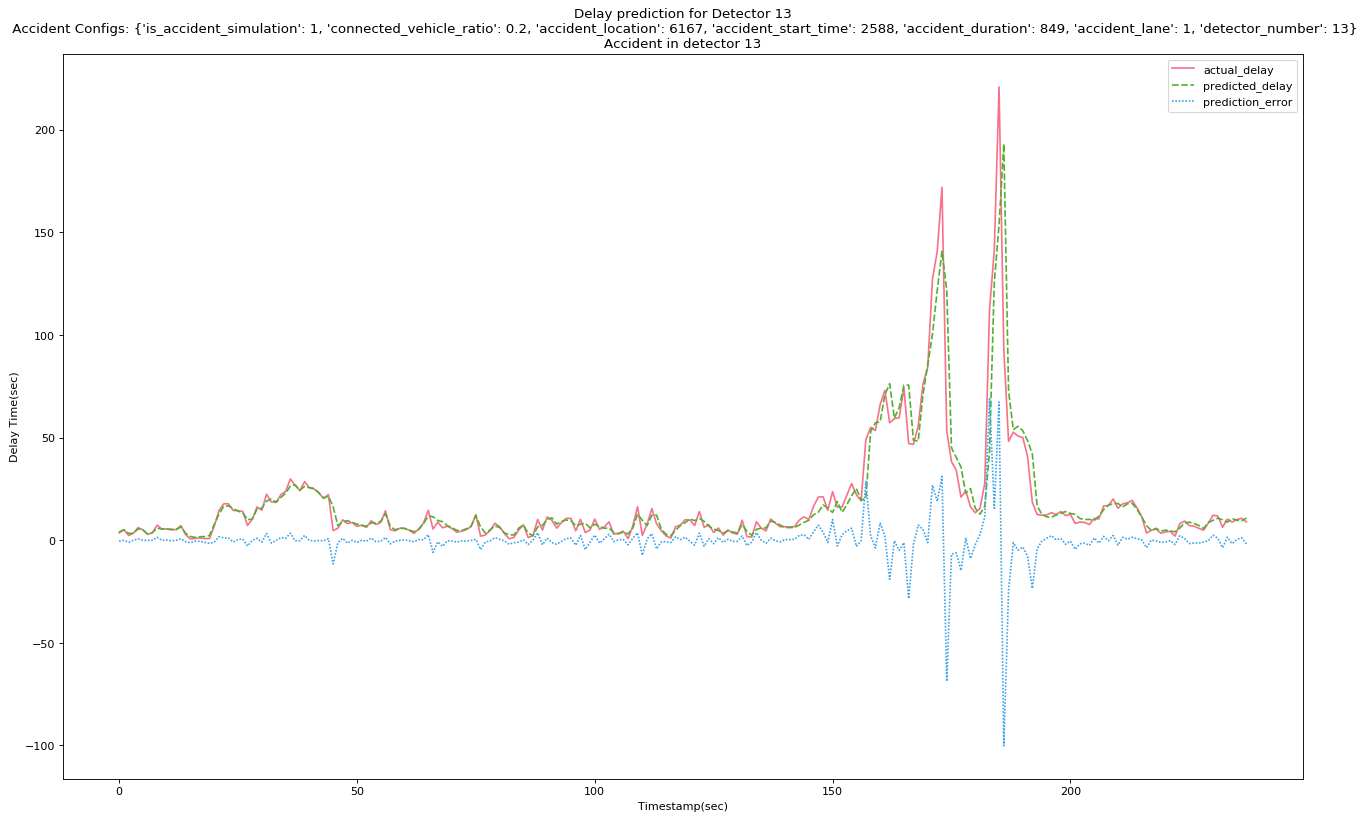

In [9]:
# CV 20%
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0.2,
    "accident_location" : 6167,
    "accident_start_time" : 2588,
    "accident_duration" : 849,
    "accident_lane" : 1,
    "detector_number" : 13
}
plot_delay_predictions(df,simulation_configs)

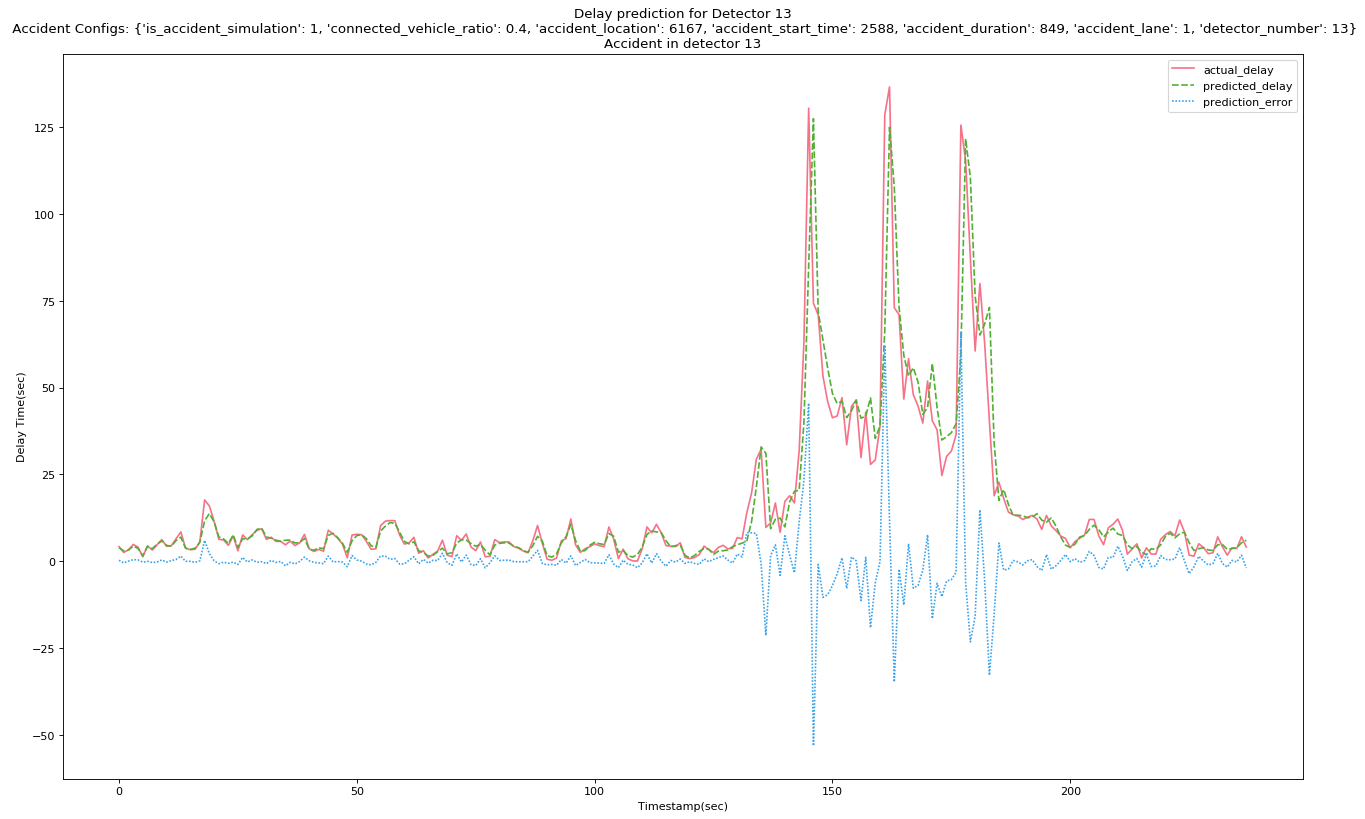

In [10]:
# CV 40%
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0.4,
    "accident_location" : 6167,
    "accident_start_time" : 2588,
    "accident_duration" : 849,
    "accident_lane" : 1,
    "detector_number" : 13
}
plot_delay_predictions(df,simulation_configs)

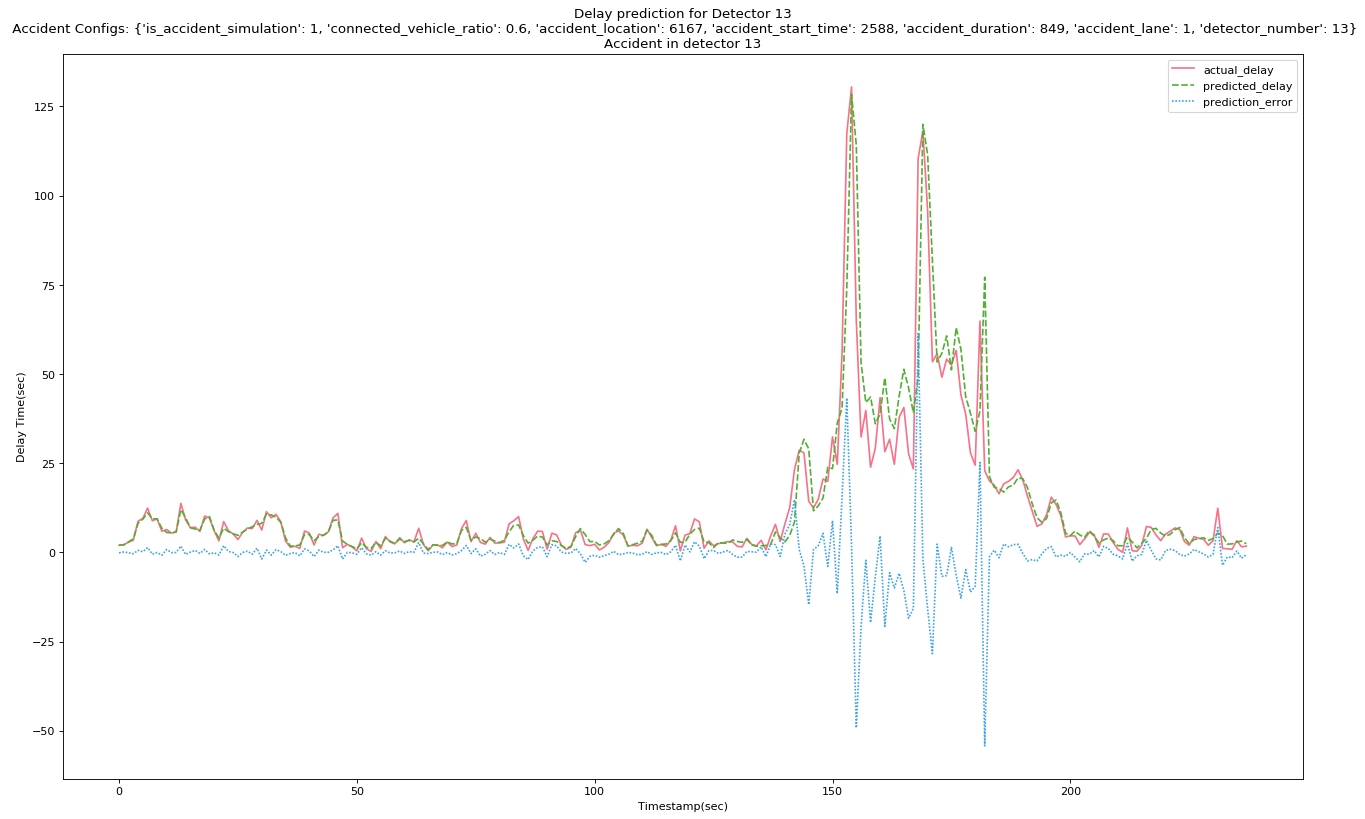

In [11]:
# CV 60%
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0.6,
    "accident_location" : 6167,
    "accident_start_time" : 2588,
    "accident_duration" : 849,
    "accident_lane" : 1,
    "detector_number" : 13
}
plot_delay_predictions(df,simulation_configs)

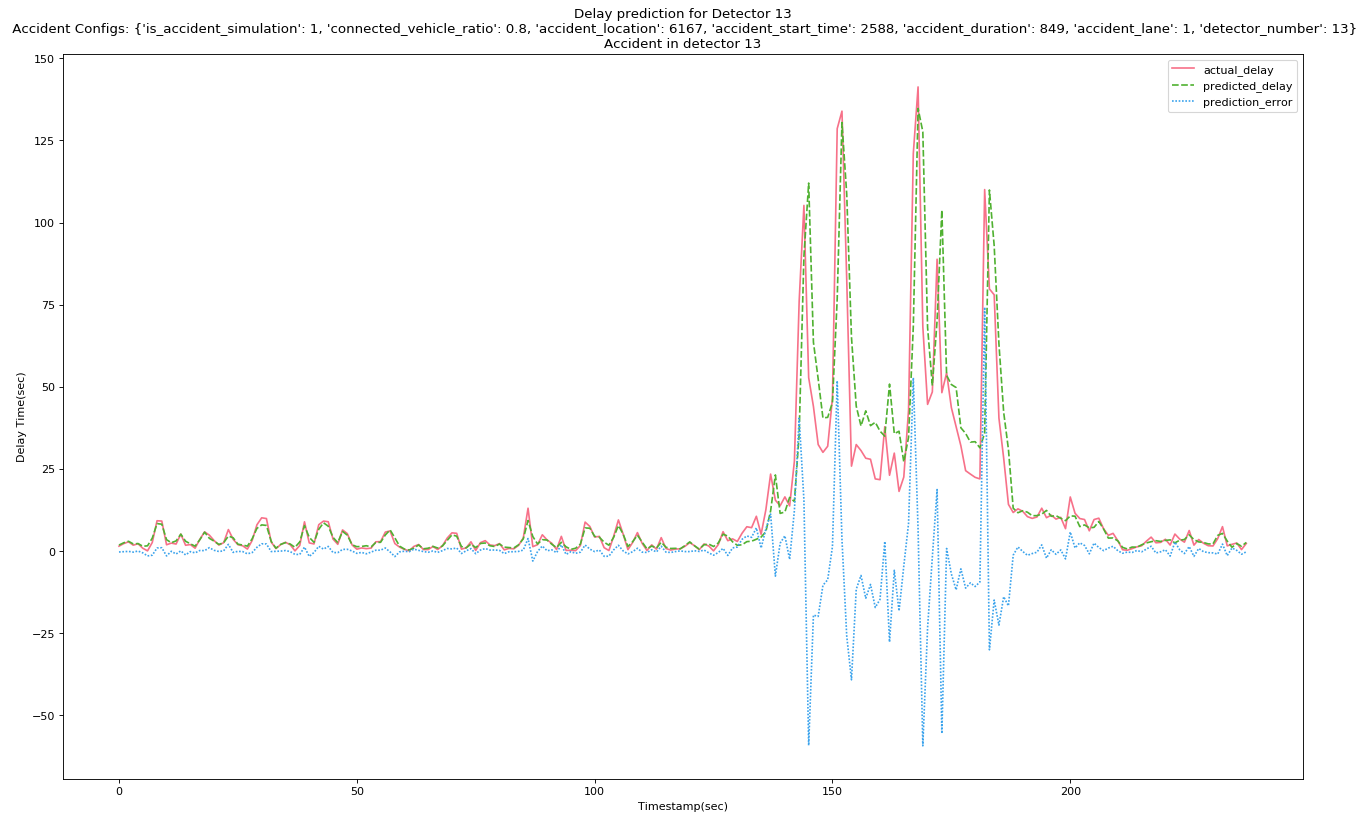

In [12]:
# CV 80%
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0.8,
    "accident_location" : 6167,
    "accident_start_time" : 2588,
    "accident_duration" : 849,
    "accident_lane" : 1,
    "detector_number" : 13
}
plot_delay_predictions(df,simulation_configs)

### Incident Lane Change

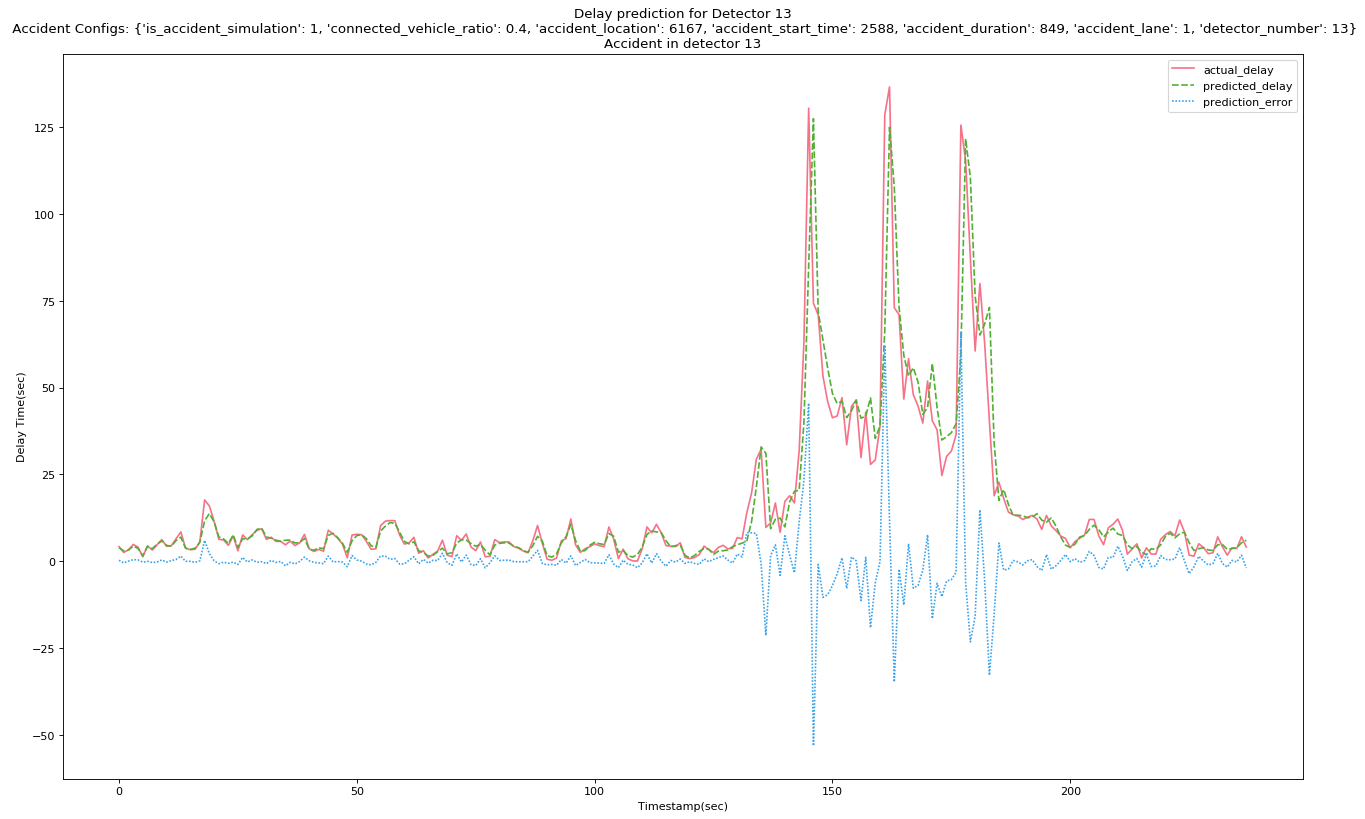

In [13]:
# Lane 1
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0.4,
    "accident_location" : 6167,
    "accident_start_time" : 2588,
    "accident_duration" : 849,
    "accident_lane" : 1,
    "detector_number" : 13
}
plot_delay_predictions(df,simulation_configs)

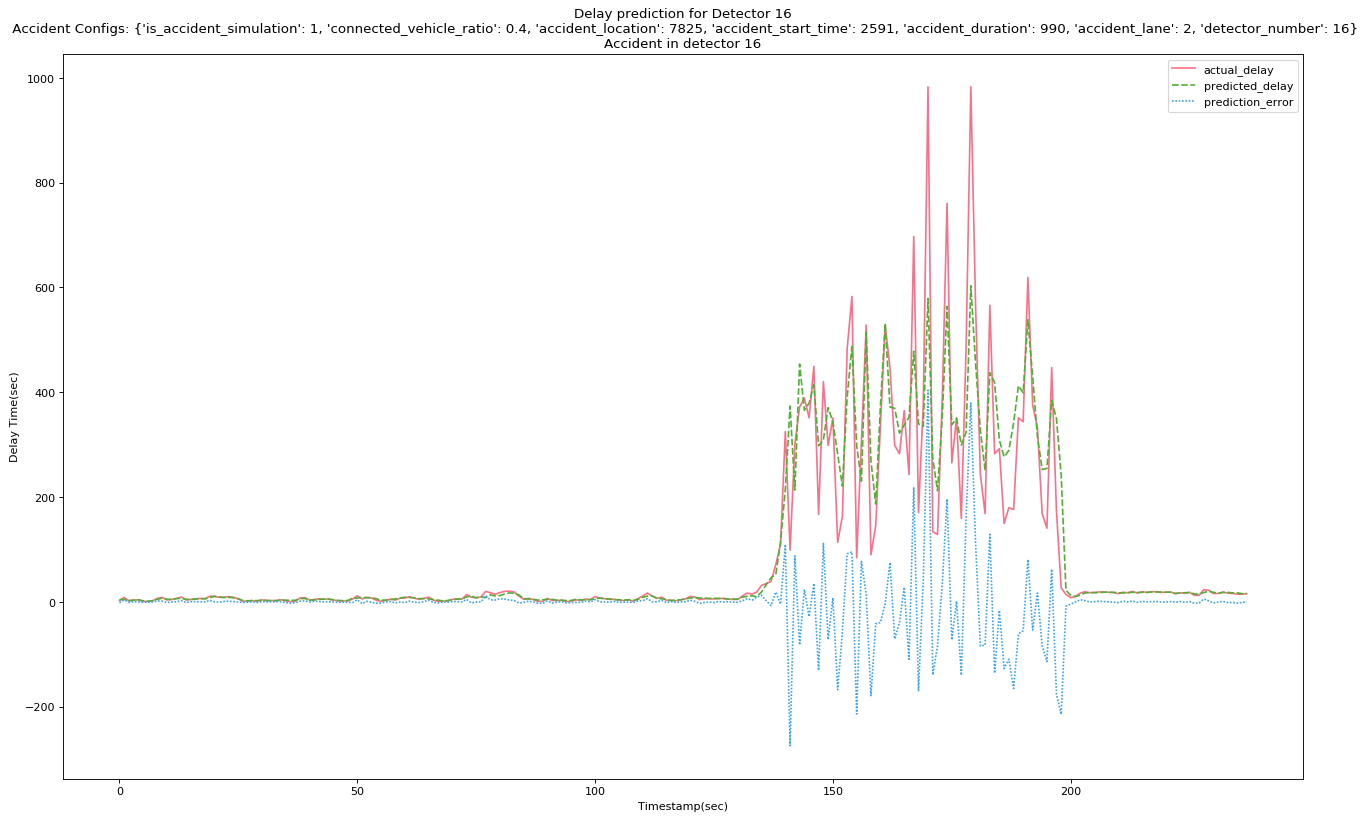

In [14]:
# Lane 2
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0.4,
    "accident_location" : 7825,
    "accident_start_time" : 2591,
    "accident_duration" : 990,
    "accident_lane" : 2,
    "detector_number" : 16
}
plot_delay_predictions(df,simulation_configs)

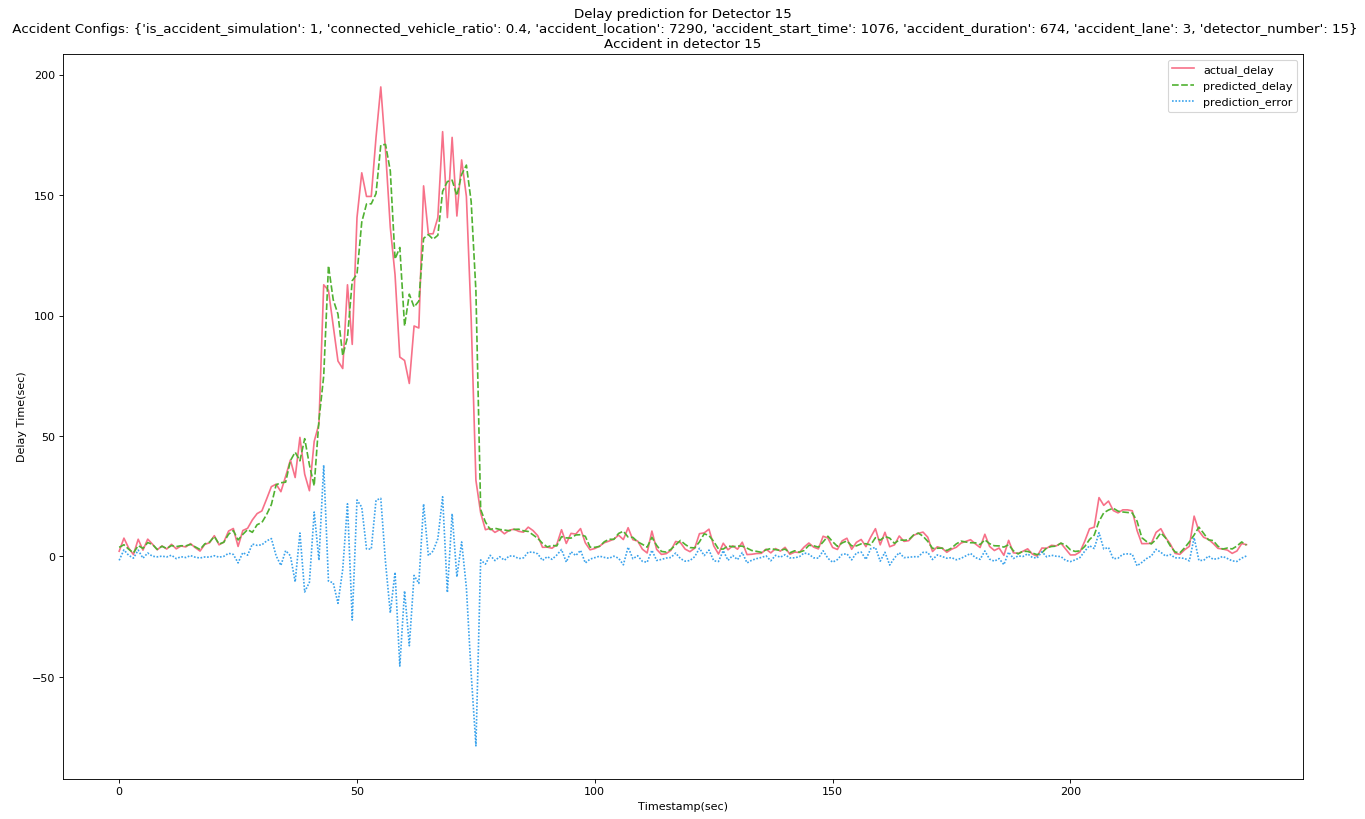

In [15]:
# Lane 3
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0.4,
    "accident_location" : 7290,
    "accident_start_time" : 1076,
    "accident_duration" : 674,
    "accident_lane" : 3,
    "detector_number" : 15
}
plot_delay_predictions(df,simulation_configs)

### Accident Duration

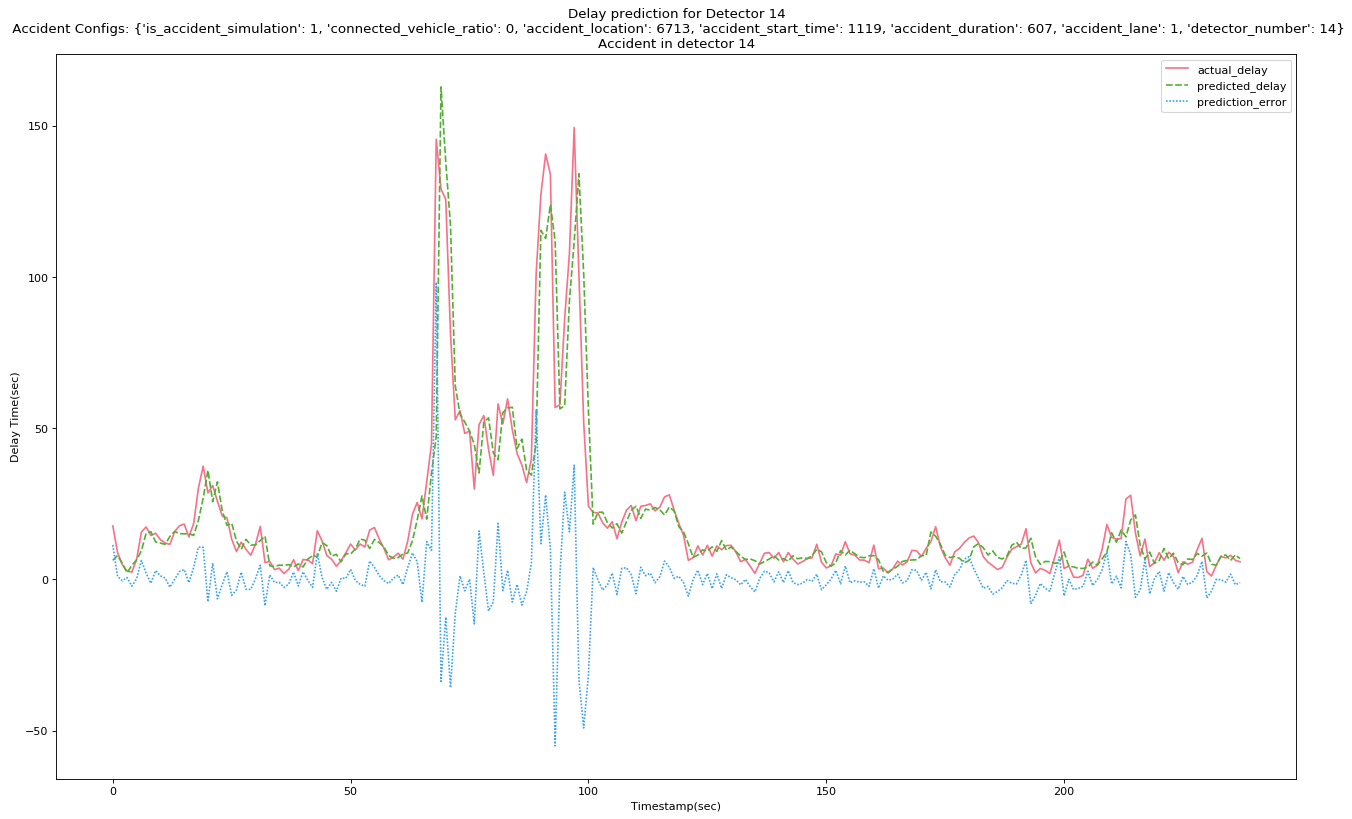

In [16]:
# Short
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0,
    "accident_location" : 6713,
    "accident_start_time" : 1119,
    "accident_duration" : 607,
    "accident_lane" : 1,
    "detector_number" : 14
}
plot_delay_predictions(df,simulation_configs)

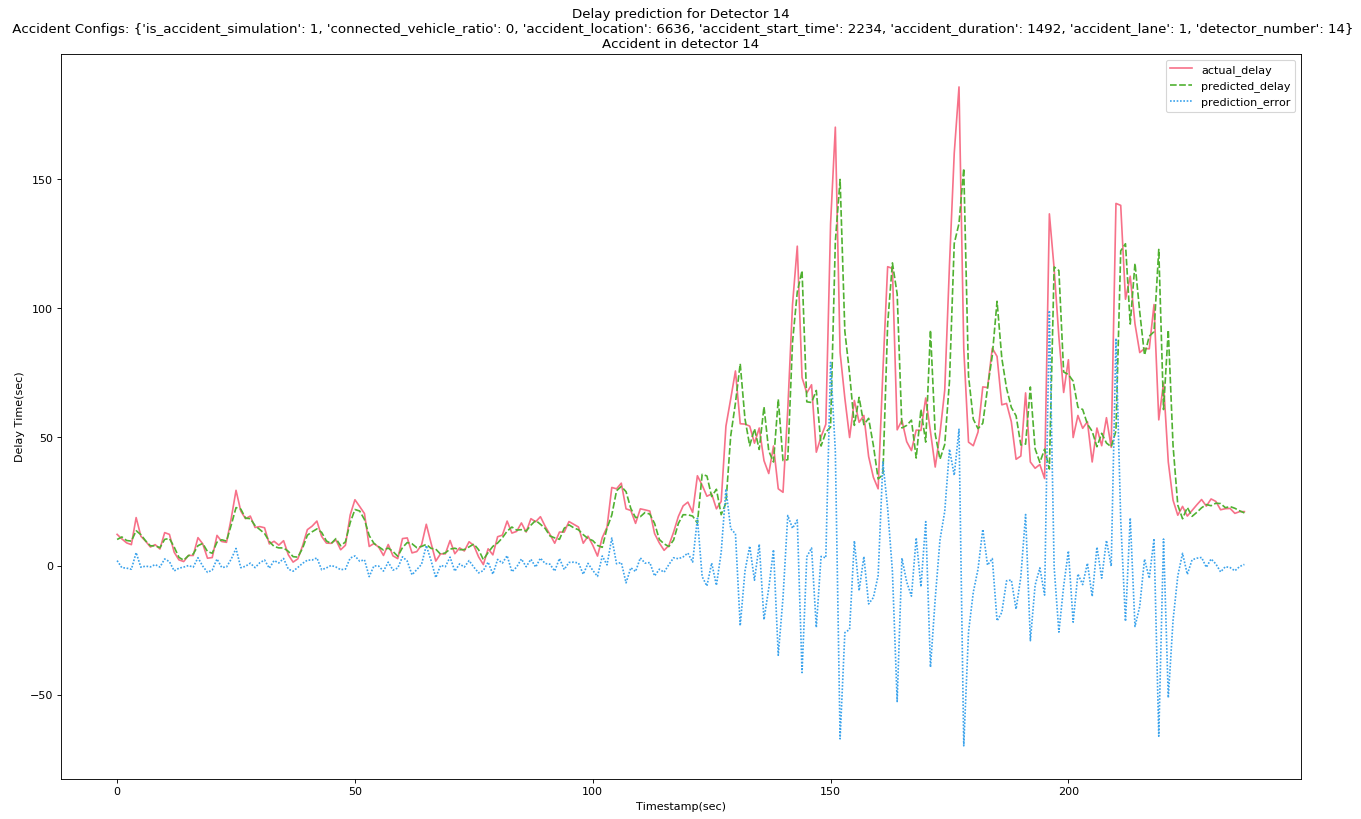

In [17]:
# Long
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio" : 0,
    "accident_location" : 6636,
    "accident_start_time" : 2234,
    "accident_duration" : 1492,
    "accident_lane" : 1,
    "detector_number" : 14
}
plot_delay_predictions(df,simulation_configs)

### Possible Configuration Means

In [81]:
df.columns[:20]

Index(['simulation_run', 'connected_vehicle_ratio', 'is_accident_simulation',
       'accident_location', 'accident_start_time', 'accident_duration',
       'accident_lane', 'prev_detector_detector_number',
       'next_detector_detector_number', 'detector_number', 'timestamp',
       'time_after_accident_started', 'distance_to_accident',
       'is_accident_timestamp', 'flow_vehph', 'density_vehpkm',
       'avg_speed_kmph', 'section_travel_time_sec', 'delay_time_sec',
       'flow_vehph_lag1'],
      dtype='object')

In [89]:
df.groupby(by=["is_accident_simulation", "accident_lane", "connected_vehicle_ratio"])["flow_vehph","density_vehpkm","avg_speed_kmph","section_travel_time_sec","delay_time_sec"].mean()

flow_vehph  \
is_accident_simulation accident_lane connected_vehicle_ratio                
0                      0             0.0                      1409.142118   
1                      1             0.0                      1394.705692   
                                     0.1                      1403.404028   
                                     0.2                      1399.205778   
                                     0.3                      1401.880371   
                                     0.4                      1403.856019   
                                     0.5                      1405.949160   
                                     0.6                      1405.821757   
                                     0.7                      1417.098649   
                                     0.8                      1405.071743   
                       2             0.0                      1411.218500   
                                     0.1                      1418.495819   
                                     0.2                      1414.053621   
                                     0.3                      1415.594448   
                                     0.4                      1418.313852   
                                     0.5                      1423.194962   
                                     0.6                      1420.098987   
                                     0.7                      1429.926918   
                                     0.8                      1423.597650   
                       3             0.0                      1397.223262   
                                     0.1                      1407.623526   
                                     0.2                      1405.009654   
                                     0.3                      1404.268908   
                                     0.4                      1408.576230   
                                     0.5                      1410.184074   
                                     0.6                      1410.683473   
                                     0.7                      1413.128451   
                                     0.8                      1404.772309   

                                                              density_vehpkm  \
is_accident_simulation accident_lane connected_vehicle_ratio                   
0                      0             0.0                           11.618672   
1                      1             0.0                           11.286896   
                                     0.1                           11.025576   
                                     0.2                           10.537161   
                                     0.3                           10.142374   
                                     0.4                            9.773731   
                                     0.5                            9.180222   
                                     0.6                            9.016455   
                                     0.7                            9.119333   
                                     0.8                            8.651733   
                       2             0.0                           12.953581   
                                     0.1                           12.384311   
                                     0.2                           12.074407   
                                     0.3                           11.681484   
                                     0.4                           11.094533   
                                     0.5                           10.682510   
                                     0.6                           10.060176   
                                     0.7                           10.272458   
                                     0.8                            9.811712   
                       3             0.0                           11.79

### Autonomous Connected Vehicle Incident Local Area Improvement

In [102]:
simulation_configs = {
    "is_accident_simulation" : 1,
    #"connected_vehicle_ratio" : 0.6,
    "accident_location" : 6636,
    "accident_start_time" : 2234,
    "accident_duration" : 1492,
    "accident_lane" : 1,
    #"detector_number" : 14
}
local_incident_data = data_slicer(df,simulation_configs)
local_incident_data[
    (local_incident_data.detector_number == 13)
    | (local_incident_data.detector_number == 14)
    | (local_incident_data.detector_number == 15)
].groupby(["connected_vehicle_ratio","detector_number"])["flow_vehph","density_vehpkm","avg_speed_kmph","section_travel_time_sec","delay_time_sec"].mean()

flow_vehph  density_vehpkm  \
connected_vehicle_ratio detector_number                                
0.0                     13               1556.638655       20.295814   
                        14               1680.000000       25.097735   
                        15               1305.546218        9.615377   
0.1                     13               1589.579832       19.947675   
                        14               1746.554622       25.714416   
                        15               1348.907563        9.810011   
0.2                     13               1646.722689       24.034475   
                        14               1694.789916       25.195235   
                        15               1301.512605        8.893966   
0.3                     13               1521.008403       16.805940   
                        14               1742.184874       25.512422   
                        15               1336.470588        8.747716   
0.4                     13               1666.890756       25.189989   
                        14               1739.159664       28.401926   
                        15               1272.268908        8.329949   
0.5                     13               1425.882353        9.126181   
                        14               1643.697479       19.044861   
                        15               1421.848739        8.888538   
0.6                     13               1526.722689       15.365494   
                        14               1717.983193       22.693878   
                        15               1394.621849        8.711833   
0.7                     13               1608.067227       18.535231   
                        14               1801.680672       25.220393   
                        15               1403.697479        8.446109   
0.8                     13               1491.428571       13.061224   
                        14               1695.462185       21.372279   
                        15               1397.310924        8.061329   

                                         avg_speed_kmph  \
connected_vehicle_ratio detector_number                   
0.0                     13                    51.763118   
                        14                    46.775046   
                        15                    71.311909   
0.1                     13                    53.230465   
                        14                    49.144610   
                        15                    71.982592   
0.2                     13                    49.604808   
                        14                    52.840149   
                        15                    76.719983   
0.3                     13                    60.547504   
                        14                    53.938037   
                        15                    79.764624   
0.4                     13                    49.425941   
                        14                    45.925810   
                        15                    82.211634   
0.5                     13                    82.015267   
                        14                    63.381425   
                        15                    82.119889   
0.6                     13                    68.862392   
                        14                    61.925863   
                        15                    85.649117   
0.7                     13                    65.682433   
                        14                    62.162317   
                        15                    88.286021   
0.8                     13                    78.339180   
                        14                    67.084356   
                        15                    89.933684   

                                         section_travel_time_sec  \
connected_vehicle_ratio detector_number                            
0.0                     13                             50.897986   
                        14           

### Autonomous Connected Vehicle Incident Global Area Improvement

In [105]:
simulation_configs = {
    "is_accident_simulation" : 1,
    #"connected_vehicle_ratio" : 0.6,
    "accident_location" : 6636,
    "accident_start_time" : 2234,
    "accident_duration" : 1492,
    "accident_lane" : 1,
    #"detector_number" : 14
}
local_incident_data = data_slicer(df,simulation_configs)
local_incident_data.groupby(["connected_vehicle_ratio"])["flow_vehph","density_vehpkm","avg_speed_kmph","section_travel_time_sec","delay_time_sec"].sum().to_csv()

'connected_vehicle_ratio,flow_vehph,density_vehpkm,avg_speed_kmph,section_travel_time_sec,delay_time_sec\n0.0,6903040.0,58805.888198757784,330043.4906393596,154337.19268019206,68164.77888708758\n0.1,6991200.0,57049.24844720484,344824.81885114906,146740.1322150595,60567.71842195591\n0.2,6971600.0,59041.71428571428,348236.59313686297,151971.19257258033,65798.77877947626\n0.3,7008320.0,54393.10559006209,366534.2922277722,135511.08534198935,49338.67154888593\n0.4,7010880.0,61739.02484472033,364353.67093906086,246351.19782810152,160178.78403499725\n0.5,7128160.0,47360.2298136647,404180.6375324678,116332.85807040305,30160.44427729944\n0.6,7039920.0,47102.28571428566,416758.55221778114,116428.14397316801,30255.73018006394\n0.7,7134640.0,48770.93167701878,424222.94337662304,117556.79391423143,31384.380121127684\n0.8,7065680.0,45239.83850931686,435694.6549050965,110968.43523548718,24796.021442383324\n'

In [ ]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio": 0,
    "accident_location" : 6932,
    "accident_start_time" : 2681,
    "accident_duration" : 1245,
    "accident_lane" : 1,
    "detector_number" : 15
}
plot_delay_predictions(df,simulation_configs)

In [ ]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio": 0.5,
    "accident_location" : 6167,
    "accident_start_time" : 2588,
    "accident_duration" : 849,
    "accident_lane" : 1,
    "detector_number" : 15
}
plot_delay_predictions(df,simulation_configs)

In [ ]:
df[
    (df.connected_vehicle_ratio == 0.5)
][
    [
    "is_accident_simulation",
    "accident_location",
    "accident_start_time",
    "accident_duration",
    "accident_lane"]
].drop_duplicates()